In [1]:
from fink_utils.sso.spins import estimate_sso_params, func_hg1g2, spin_angle

from fink_utils.sso.periods import estimate_synodic_period  # v0.21.0 or more
import requests
import time
import io

import numpy as np
import pandas as pd

import rocks
import phunk

import matplotlib.pyplot as plt

from scipy.optimize import least_squares
from scipy import linalg

from astropy.coordinates import SkyCoord

import sys

sys.path.append("..")
import ssptools

# import seaborn as sns
# sns.set_context("poster")

from erfa import ErfaWarning

 [astropy.utils.exceptions]


In [ ]:
def cos_aspect_angle(ra, dec, ra0, dec0):
    """
    Compute the cosine of the aspect angle from the coordinates of the target and the coordinates of its pole.

    Parameters:
    ra (float): Right ascension of the target in radians.
    dec (float): Declination of the target in radians.
    ra0 (float): Right ascension of the pole in radians.
    dec0 (float): Declination of the pole in radians.

    Returns:
    float: The cosine of the aspect angle
    """

    return np.sin(dec) * np.sin(dec0) + np.cos(dec) * np.cos(dec0) * np.cos(ra - ra0)


def rotation_phase(t, W0, W1, t0):
    """
    Compute the rotational phase, from the location of the prime meridian at
    at reference epoch (W0, t0), and an angular velocity (W1)

    Parameters:
    t (float): Time (JD)
    W0 (float): Location of the prime meridian at reference epoch (radian)
    W1 (float): Angular velocity of the target in radians/day.
    t0 (float): Reference epoch (JD)

    Returns:
    float: The rotational phase W (radian)
    """
    return W0 + W1 * (t - t0)


def subobserver_longitude(ra, dec, ra0, dec0, W):
    """
    Compute the subobserver longitude (radian) from the coordinates of the target, the coordinates of its pole, and its rotation phase

    Parameters:
    ra (float): Right ascension of the target in radians.
    dec (float): Declination of the target in radians.
    ra0 (float): Right ascension of the pole in radians.
    dec0 (float): Declination of the pole in radians.
    W (float): Rotation phase of the target in radians.

    Returns:
    float: The subobserver longitude in radians.
    """

    x = -np.cos(dec0) * np.sin(dec) + np.sin(dec0) * np.cos(dec) * np.cos(ra - ra0)
    y = -np.cos(dec0) ** np.sin(ra - ra0)
    return W - np.arctan2(x, y)

In [2]:
def func_sshg1g2(pha, h, g1, g2, alpha0, delta0, period, a_b, a_c, phi0, t0):
    """Return f(H, G1, G2, R, alpha0, delta0) part of the lightcurve in mag space

    Parameters
    ----------
    pha: array-like [4, N]
        List containing [phase angle in radians, RA in radians, Dec in radians, time (jd)]
    h: float
        Absolute magnitude in mag
    G1: float
        G1 parameter (no unit)
    G2: float
        G2 parameter (no unit)
    alpha0: float
        RA of the spin (radian)
    delta0: float
        Dec of the spin (radian)
    period: float
        Spin period (days)
    a_b: float
        Equatorial axes ratio
    a_c: float
        Polar axes ratio
    phi0: float
        Initial rotation phase at reference time t0 (radian)
    t0: float
        Reference time (jd)

    Returns
    -------
    out: array of floats
        H - 2.5 log(f(G1G2)) - 2.5 log(f(spin, shape))
    """
    ph = pha[0]
    ra = pha[1]
    dec = pha[2]
    ep = pha[3]

    # Standard HG1G2 part: h + f(alpha, G1, G2)
    func1 = func_hg1g2(ph, h, g1, g2)

    # Spin part
    cos_aspect = cos_aspect_angle(ra, dec, alpha0, delta0)
    cos_aspect_2 = cos_aspect**2
    sin_aspect_2 = 1 - cos_aspect_2
    
    # V1: Synodic
    rot_phase = (2 * np.pi * (ep - t0) / period + phi0) % (2 * np.pi)
    
    # V2: Sidereal
    W = rotation_phase(ep, phi0, 2*np.pi*period, t0)
    rot_phase = subobserver_longitude(ra, dec, alpha0, delta0, W):

    # new
    # https://ui.adsabs.harvard.edu/abs/1985A%26A...149..186P/abstract
    func2 = np.sqrt(
        sin_aspect_2 * (np.cos(rot_phase) ** 2 + (a_b**2) * np.sin(rot_phase) ** 2)
        + cos_aspect_2 * a_c**2
    )
    func2 = -2.5 * np.log10(func2)

    return func1 + func2

# Tests of fitting

/tmp/ipykernel_17169/3086305237.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


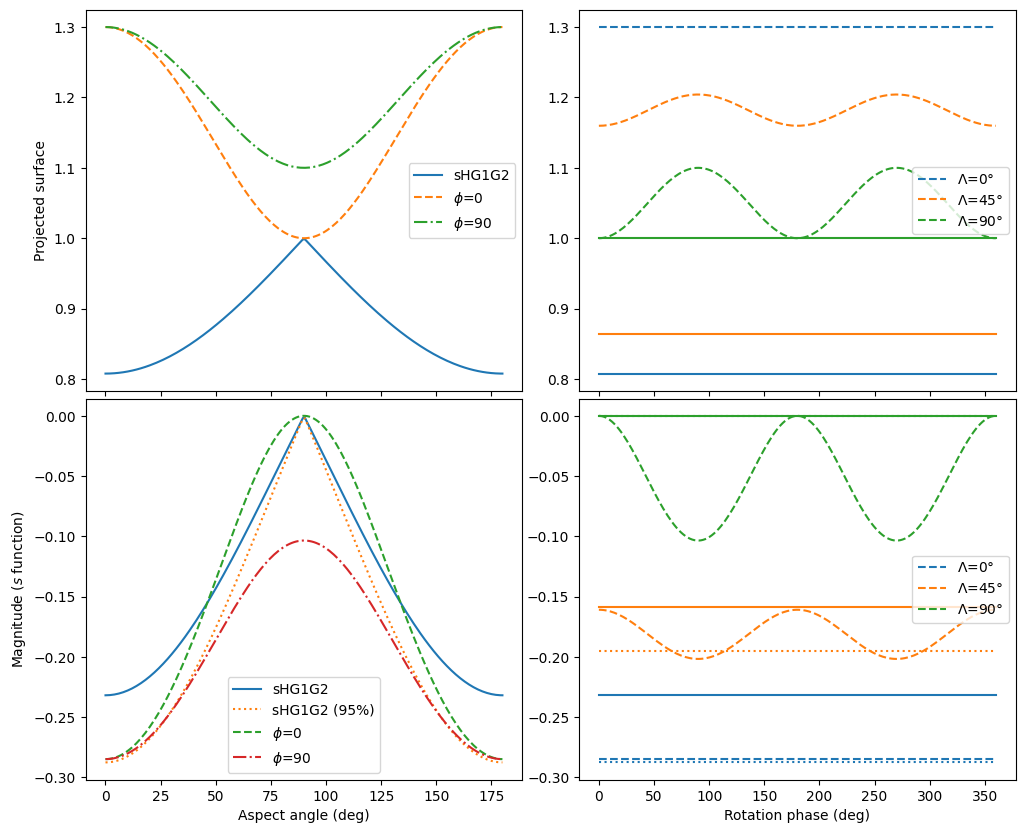

In [4]:
# Test values
a_b = 1.1
a_c = 1.3

# Derive the R parameter
a = 1
b = a / a_b
c = a / a_c
R = c * (a + b) / (2 * a * b)

# Change of aspect
nbd = 180
aspect = np.linspace(0, np.pi, nbd)

cos_aspect = np.cos(aspect)
cos_aspect_2 = cos_aspect**2
sin_aspect_2 = 1 - cos_aspect_2
rot_phase = 0
rot_phase_b = np.pi / 2

factor = 0.95

func1 = 1 - (1 - R) * np.abs(cos_aspect)
func1_b = 1 - (1 - R * factor) * np.abs(cos_aspect)

func2 = np.sqrt(
    sin_aspect_2 * (np.cos(rot_phase) ** 2 + (a_b**2) * np.sin(rot_phase) ** 2)
    + cos_aspect_2 * a_c**2
)

func2_b = np.sqrt(
    sin_aspect_2 * (np.cos(rot_phase_b) ** 2 + (a_b**2) * np.sin(rot_phase_b) ** 2)
    + cos_aspect_2 * a_c**2
)


fig, ax = plt.subplots(
    2, 2, figsize=(12, 10), gridspec_kw={"wspace": 0.13, "hspace": 0.02}
)

ax[0, 0].plot(np.degrees(aspect), func1, label="sHG1G2")
ax[0, 0].plot(np.degrees(aspect), func2, ls="--", label="$\phi$=0")
ax[0, 0].plot(np.degrees(aspect), func2_b, ls="-.", label="$\phi$=90")

ax[1, 0].plot(np.degrees(aspect), 2.5 * np.log10(func1), label="sHG1G2")
ax[1, 0].plot(
    np.degrees(aspect), 2.5 * np.log10(func1_b), ls="dotted", label="sHG1G2 (95%)"
)
ax[1, 0].plot(np.degrees(aspect), -2.5 * np.log10(func2), ls="--", label="$\phi$=0")
ax[1, 0].plot(np.degrees(aspect), -2.5 * np.log10(func2_b), ls="-.", label="$\phi$=90")


rot_phase = np.linspace(0, 2 * np.pi, 180)

for i, aspect in enumerate([0, np.pi / 4, np.pi / 2]):
    cos_aspect = np.cos(aspect)
    cos_aspect_2 = cos_aspect**2
    sin_aspect_2 = 1 - cos_aspect_2

    func1 = np.full(nbd, 1 - (1 - R) * np.abs(cos_aspect))
    func1_b = np.full(nbd, 1 - (1 - R * factor) * np.abs(cos_aspect))
    func2 = np.sqrt(
        sin_aspect_2 * (np.cos(rot_phase) ** 2 + (a_b**2) * np.sin(rot_phase) ** 2)
        + cos_aspect_2 * a_c**2
    )
    ax[0, 1].plot(np.degrees(rot_phase), func1, color=f"C{i}")
    ax[0, 1].plot(
        np.degrees(rot_phase),
        func2,
        color=f"C{i}",
        ls="--",
        label=f"$\Lambda$={np.degrees(aspect):.0f}°",
    )

    ax[1, 1].plot(np.degrees(rot_phase), 2.5 * np.log10(func1), color=f"C{i}")
    ax[1, 1].plot(
        np.degrees(rot_phase), 2.5 * np.log10(func1_b), color=f"C{i}", ls="dotted"
    )
    ax[1, 1].plot(
        np.degrees(rot_phase),
        -2.5 * np.log10(func2),
        color=f"C{i}",
        ls="--",
        label=f"$\Lambda$={np.degrees(aspect):.0f}°",
    )


ax[1, 1].set_xlabel("Rotation phase (deg)")
ax[1, 0].set_xlabel("Aspect angle (deg)")
ax[0, 0].set_ylabel("Projected surface")
ax[1, 0].set_ylabel("Magnitude ($s$ function)")

for a in ax.flatten():
    a.legend()

fig.tight_layout()
fig.savefig("ssHG1G2.png")

The new definition of $s(\alpha,\delta)$ leads to similar correction against aspect angle (bottom left figure). However

- it allows for rotation 
- there is a systematic offset in magnitude toward ``pole-on'' geometry, solved if R is taken as 0.95*R... why?